# Load Dataset

In [3]:
!pip install gdown
import os
import gdown
import zipfile

if not os.path.isdir("Mushrooms"):
  url = 'https://drive.google.com/uc?id=1BUD8rvVAwon48pnMmUJAKIoZE8AqTRhy'
  output = 'Mushrooms.zip'
  gdown.download(url, output, quiet=False)
  with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From: https://drive.google.com/uc?id=1BUD8rvVAwon48pnMmUJAKIoZE8AqTRhy
To: /content/Mushrooms.zip
995MB [00:13, 75.8MB/s]


In [4]:
!pip install jupyter_contrib_nbextensions
!pip install fastai
!pip install fastai --upgrade
!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 20.9MB 31.9MB/s 
     |████████████████████████████████| 481kB 39.2MB/s 
     |████████████████████████████████| 870kB 38.1MB/s 
  Created wheel for jupyter-nbextensions-configurator: filename=jupyter_nbextensions_configurator-0.4.1-py2.py3-none-any.whl size=465825 sha256=c5e80eb1646b717b876b600ce76c5e41c15160bc506fcf49d31c197589fab2a3
  Stored in directory: /root/.cache/pip/wheels/15/df/fe/2a74fe34709e7fdc5ae153a768675d9fda93cc7d5133ed1fb0
  Created wheel for jupyter-latex-envs: filename=jupyter_latex_envs-1.4.6-py2.py3-none-any.whl size=963395 sha256=8bf1a3a7c5d0c80050e668baa69b9a218f1fe4424a460699db98244f8f6e4b90
  Stored in directory: /root/.cache/pip/wheels/0d/71/2a/164491997299b9f2479a251e254323fe35d946779e18f27956
Successfully built jupyter-nbextensions-configurator jupyter-latex-envs
     |████████████████████████████████| 358kB 4.5MB/s 
     |████████████████████████████████| 40kB 4.6MB/s 
  Found existing installation: fastai 1.0.61
   

In [5]:
import numpy as np 
import pandas as pd 
import os


from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders
from fastai.metrics import error_rate

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)

In [7]:
batch_size=64
classes = ['Boletus','Entoloma','Russula','Suillus','Lactarius','Amanita','Agaricus','Hygrocybe','Cortinarius']

In [8]:
path = Path("Mushrooms")
print(path)

Mushrooms


In [9]:
# Read dataset and split on train and validation sets. Validation = 20% of dataset.
dls_tmp = ImageDataLoaders.from_folder(path,
                                   valid_pct=0.4,
                                   item_tfms=Resize(224),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats),
                                   num_workers=4,
                                   bs=batch_size,
                                   val_bs=batch_size,
                                  )

In [10]:
import random

def label_func(x): return x.parent.name
def dataloader_from_items(items, valid_pct):
  return ImageDataLoaders.from_path_func(
    path, 
    items, 
    label_func,
    item_tfms=Resize(224),
    batch_tfms=Normalize.from_stats(*imagenet_stats),
    num_workers=4,
    valid_pct=valid_pct,
    bs=batch_size)

valid_items = dls_tmp.valid.items
random.shuffle(valid_items)
# Split validation set on two equal parts: test and validation.
# Resulting sizes (approximately) train: 64%, validation: 16%, test: 20% of the dataset.
# Note: test should have batches of equal sizes (64 by default), otherwise predictions will crush.
test_dls = dataloader_from_items(valid_items[:len(valid_items)//batch_size//2*batch_size], valid_pct=0.0)
dls = dataloader_from_items(valid_items[len(valid_items)//batch_size//2*batch_size:]+dls_tmp.train.items, valid_pct=0.2)
print("Train size: {}, Validation size: {}, Test size: {}".format(
    len(dls.train.items), len(dls.valid.items), len(test_dls.items)))

Train size: 4348, Validation size: 1086, Test size: 1280


Train/Validation


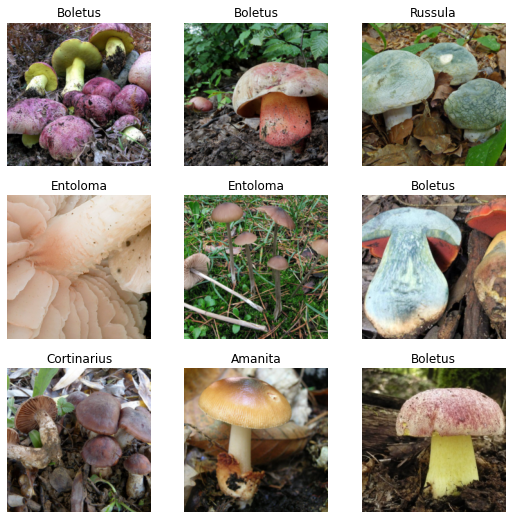

In [11]:
print("Train/Validation")
dls.show_batch()

Test


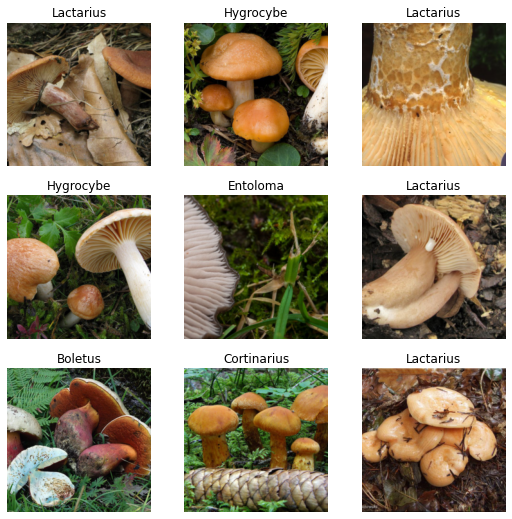

In [12]:
print("Test")
test_dls.show_batch()

# Helper functions

In [13]:
def show_in_row(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

def tensor_to_numpy_image(img):
  # this converts it from GPU to CPU and selects first image
  img = img.cpu().numpy()
  #convert image back to Height,Width,Channels
  img = np.transpose(img, (1,2,0))
  img = img.astype(np.uint8)
  #show the image
  return img

# Train model

In [65]:
from PIL import ImageFile
import fastai.vision.models as models
significant_reduce = 1e-2
max_iterations = 5

ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(learner):
  prev_loss = 1e9
  iteration = 0
  # Fine tune while validation loss reduces significantly
  while iteration < max_iterations 
  and (learner.recorder.loss.value is None or prev_loss - learner.recorder.loss.value > significant_reduce):
    iteration += 1
    if learner.recorder.loss.value is not None:
      prev_loss = learner.recorder.loss.value
    else:
      prev_loss = 1e9
    lr = learner.lr_find()[0]
    learner.recorder.before_epoch()
    learner.fine_tune(epochs=4, lr=lr)
    learner.recorder.after_epoch()
    
  interp = ClassificationInterpretation.from_learner(learner)
  interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
  return learner

def init_model(dls, model):
  learner = cnn_learner(dls, model, metrics=error_rate)
  learner.recorder.loss.reset()
  return learner

# ResNet50

1000000000.0


epoch,train_loss,valid_loss,error_rate,time
0,1.798075,1.210510,0.328729,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.827362,0.641819,0.209945,01:07


(#6) [0,0.8273624777793884,0.6418190002441406,0.20994475483894348,'01:07','01:07']
tensor(0.6418)


epoch,train_loss,valid_loss,error_rate,time
0,0.503595,0.718282,0.220074,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.383286,0.549346,0.165746,01:06


(#6) [0,0.3832864463329315,0.5493460297584534,0.16574585437774658,'01:06','01:06']


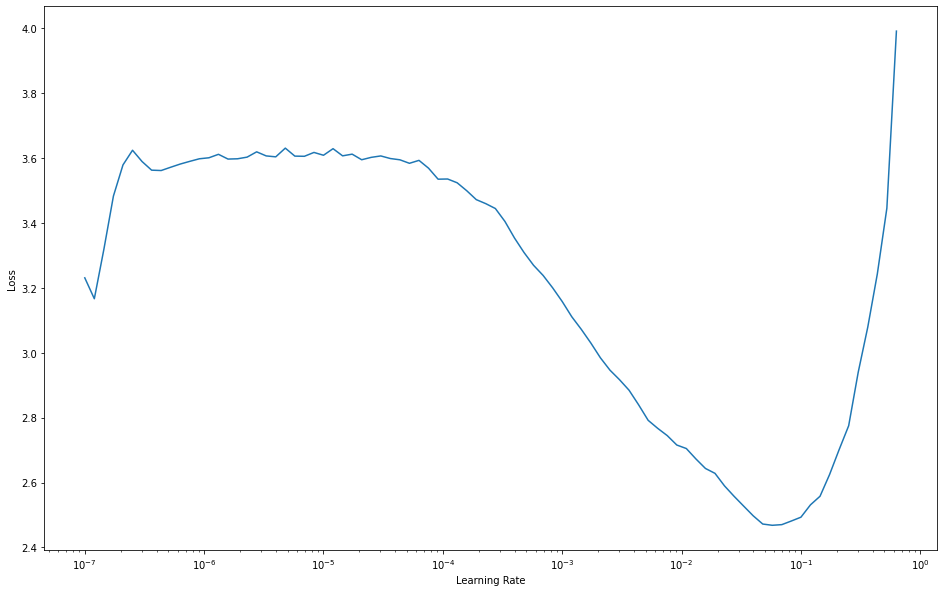

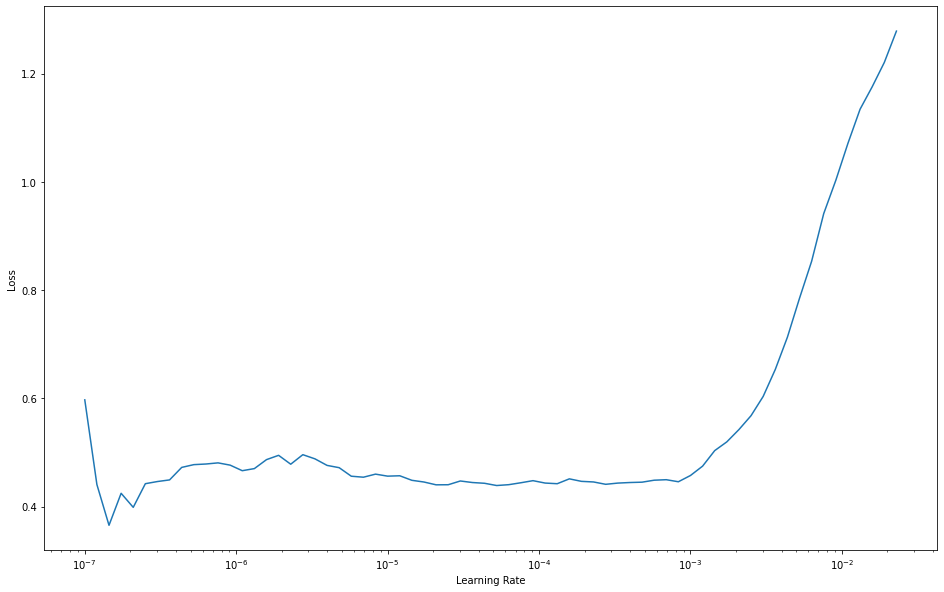

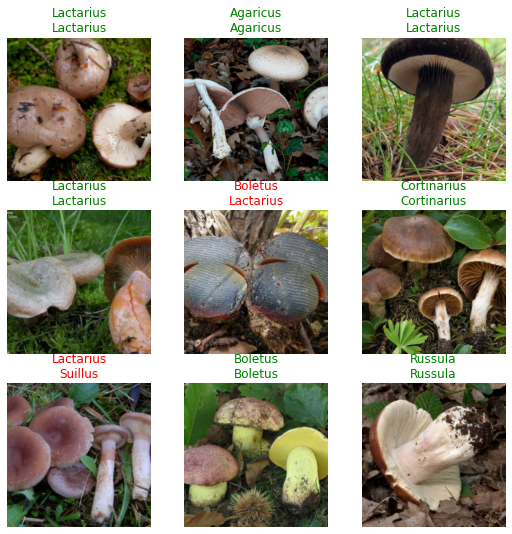

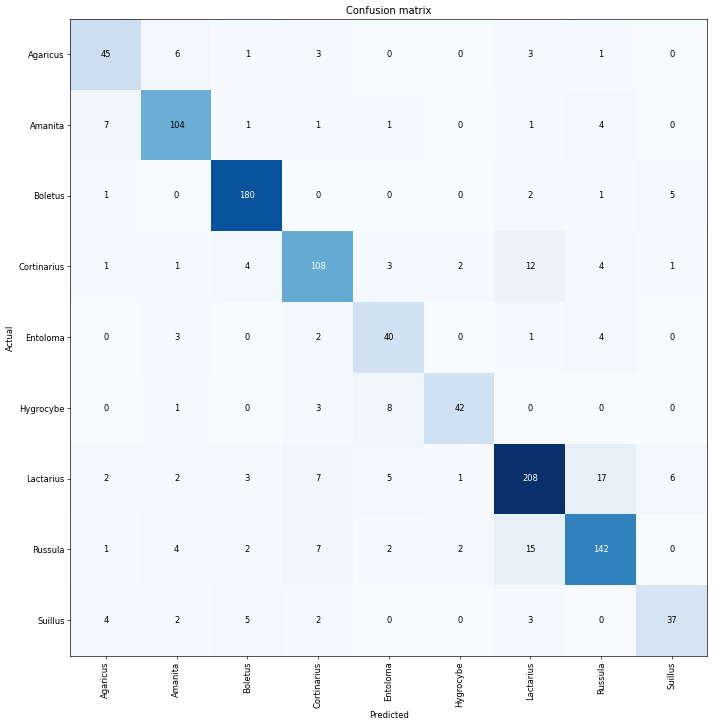

In [66]:
rn50_learner = init_model(dls, models.resnet50)
train(rn50_learner)

In [ ]:
rn50_learner.summary()

# ResNet101

1000000000.0


epoch,train_loss,valid_loss,error_rate,time
0,1.798075,1.210510,0.328729,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.827362,0.641819,0.209945,01:07


(#6) [0,0.8273624777793884,0.6418190002441406,0.20994475483894348,'01:07','01:07']
tensor(0.6418)


epoch,train_loss,valid_loss,error_rate,time
0,0.503595,0.718282,0.220074,01:05


epoch,train_loss,valid_loss,error_rate,time
0,0.383286,0.549346,0.165746,01:06


(#6) [0,0.3832864463329315,0.5493460297584534,0.16574585437774658,'01:06','01:06']


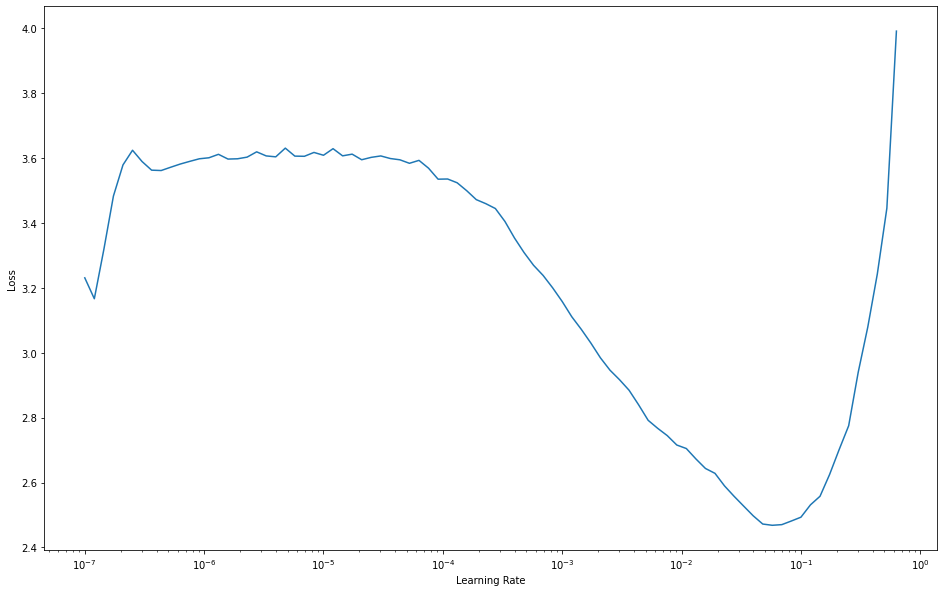

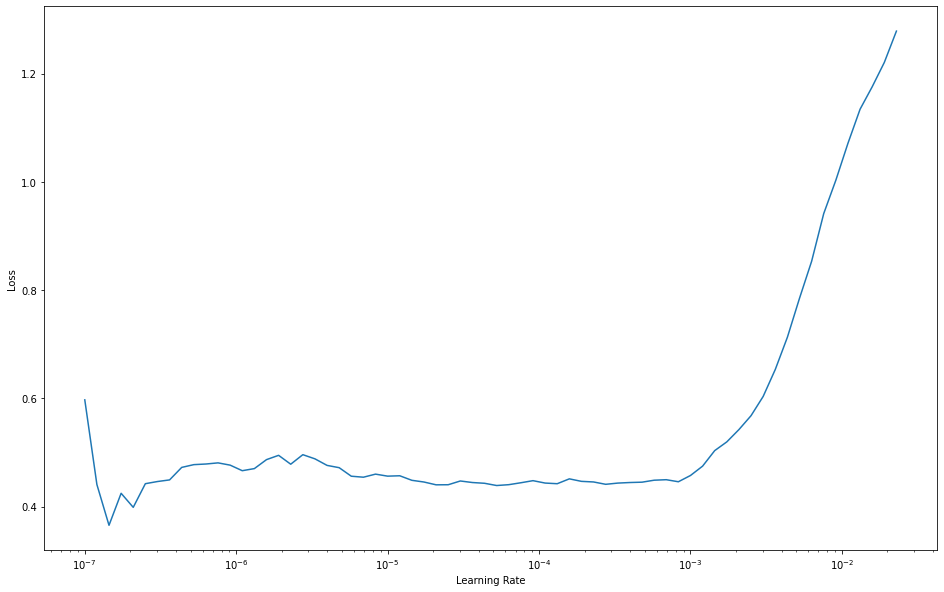

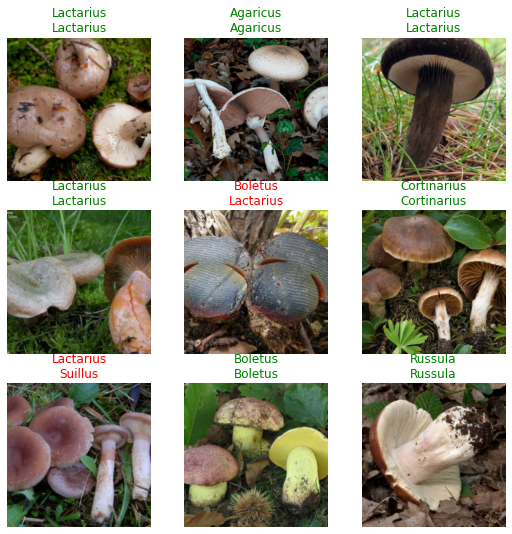

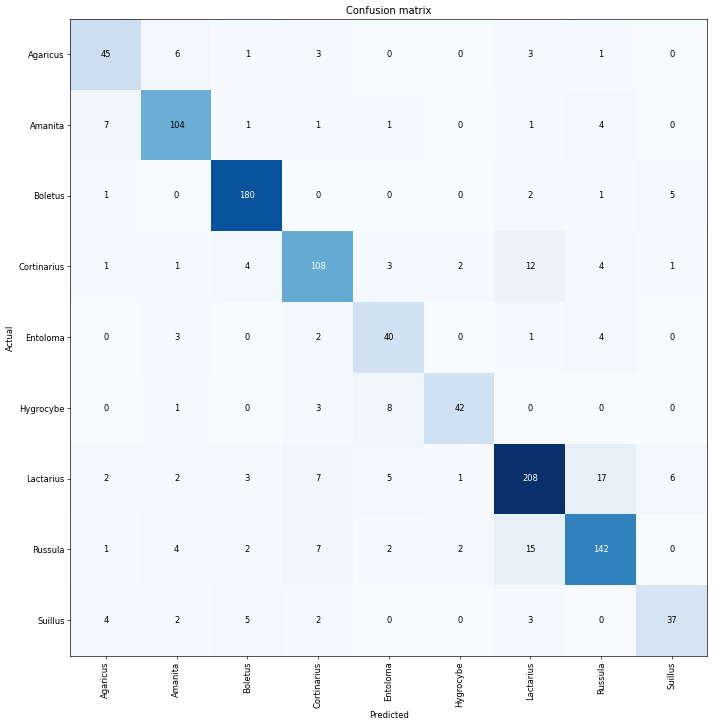

In [ ]:
rn101_learner = init_model(dls, models.resnet101)
train(rn101_learner)

In [ ]:
rn101_learner.summary()

# Alexnet

In [ ]:
alexnet_learner = init_model(dls, models.alexnet)
train(alexnet_learner)

In [ ]:
alexnet_learner.summary()

# VGG16

In [ ]:
vgg16_learner = init_model(dls, models.vgg16_bn)
train(vgg16_learner)

In [ ]:
vgg16_learner.summary()

# VGG19

In [ ]:
vgg19_learner = init_model(dls, models.vgg19_bn)
train(vgg19_learner)

In [ ]:
vgg19_learner.summary()

# Comparison

In [16]:
accuracies = []
CNNs = ["ResNet50", "ResNet101", "Alexnet", "VGG16", "VGG19"]

accuracies.append(accuracy(*rn50_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*rn101_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*alexnet_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*vgg16_learner.get_preds(dl=test_dls)).item())
accuracies.append(accuracy(*vgg19_learner.get_preds(dl=test_dls)).item())

ResNet50 accuracy on test set:  0.776562511920929


ResNet50 accuracy: 0.45
ResNet101 accuracy: 1
Alexnet accuracy: 0.55
VGG16 accuracy: 0.23
VGG19 accuracy: 0.124


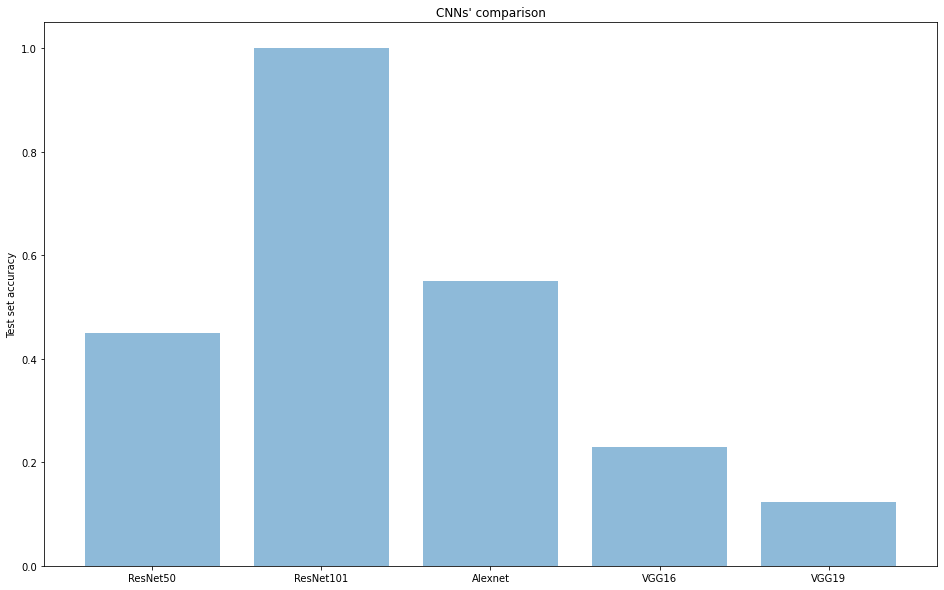

In [70]:
y_pos = np.arange(len(CNNs))
for i in range(len(accuracies)):
  print("{} test accuracy: {}".format(CNNs[i], accuracies[i]))

plt.bar(y_pos, accuracies, align='center', alpha=0.5)
plt.xticks(y_pos, CNNs)
plt.ylabel('Test set accuracy')
plt.title("CNNs' comparison")

plt.show()